# `Fitty.jl`: Nonlinear least squares regression in Julia

**Raibatak Das - 2024-APR-27**  
[Last updated - **2024-JUL-05**]

This notebook introduces the Julia package `Fitty.jl` for nonlinear least squares regression. 

Nonlinear least squares problems are common in many areas of physical and biological sciences where the objective is to fit  experimental data to a mathematical model. `Fitty.jl` can be used to estimate model parameters and their confidence intervals for such problems. 

In [1]:
using CSV, DataFrames, LaTeXStrings, KernelDensity, PythonPlot, RDatasets
using Pkg
Pkg.activate("..")
import Fitty

  Activating project at `~/quantilogix/projects/Fitty`


In [2]:
## ONLY RELEVANT ON A MAC WITH RETINA DISPLAY

# # Run macro to produce high resolution plots
# # on a retina display
# @pyplot_retina
# # Update matplotlib settings
# mpl = PythonPlot.matplotlib
# mpl.rcParams["font.size"] = 14;
# mpl.rcParams["figure.dpi"] = 180;
# mpl.rcParams["axes.axisbelow"] = true;
# mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color = mpl.colormaps["Set1"].colors);

## 1. Quick start: Rosenbrock function

The Rosenbrock function defined below is a standard test problem for nonlinear least squares minimization:
$$ f(x, y) = (1 - x)^2 + 100(y - x^2)^2 $$
This function has a global minima at (1, 1) that is hard to find because it lies within a narrow, curved valley [Ref: [Wikipedia](https://en.wikipedia.org/wiki/Rosenbrock_function)]

The function can be represented by a vector of residuals:
$$\begin{aligned}
\epsilon_1 & = 1 - x \\
\epsilon_2 & = 10(y - x^2)
\end{aligned}$$

whose sum of squares $$f(x, y) = \epsilon_1^2 + \epsilon_2^2$$ is to be minimized. 

The next code block sets up this problem and uses the `Fitty.nlsfit()` function to find optimal $x$ and $y$ starting with a guess far from the minima.

In [3]:
# Define residuals for Rosenbrock function
f(θ) = [1 - θ.x, 10*(θ.y - θ.x^2)]

# Minimize SSR starting with a non-optimal guess
guess = (x = -1.5, y = 1); # Starting guess away from global minima
fit = Fitty.nlsfit(f, guess);

Fit converged in 13 steps from intial guess [-1.5, 1.0]
to final estimate [1.0, 1.0]


The plots below show the optimizer trajectory overlaid on a contour plot of the Rosenbrock function (left) and SSR values along the trajectory (right)

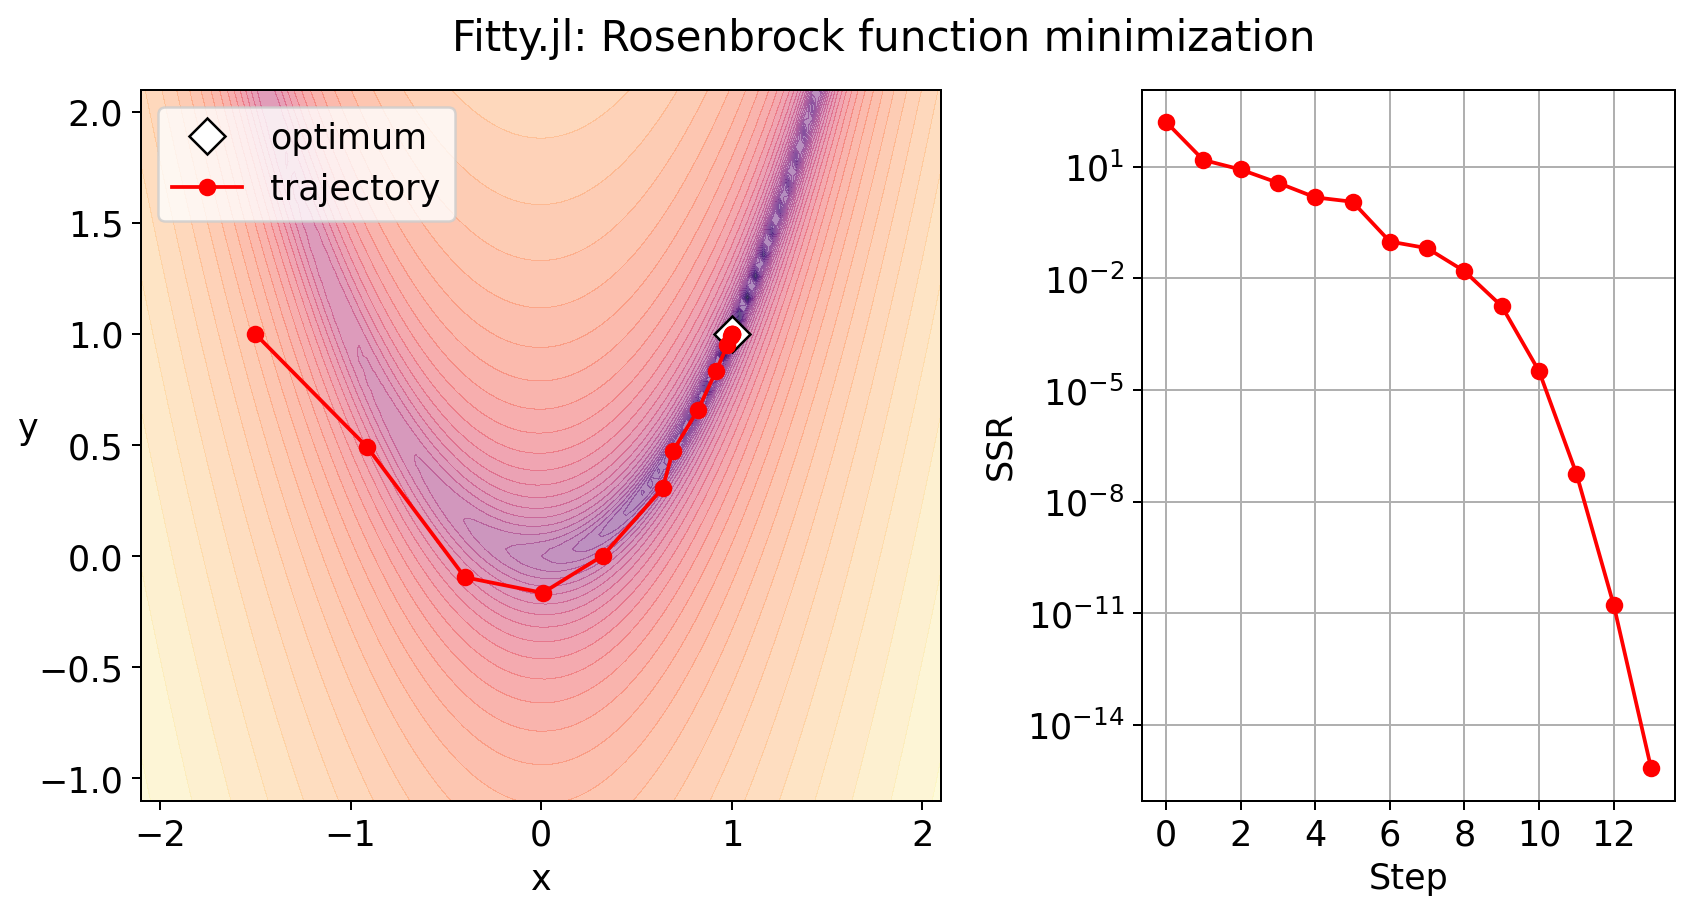

In [4]:
Rosenbrock(x, y) = sum(f((x = x, y= y)).^2)

x = collect(range(-2.1, 2.1, length = 100))
y = collect(range(-1.1, 2.1, length = 100))
z = log10.(Rosenbrock.(x', y))

fig, (ax0, ax1) = subplots(figsize = (11, 5), 
                           ncols = 2, width_ratios = [1.5, 1])

# Plot contours optimum and trajectory
ax0.plot([1], [1], "kD", ms = 10, mfc = "w", 
         label = "optimum")
ax0.contourf(x, y, z, levels = 40, cmap = "magma", 
            alpha = 0.5)

ax0.plot(fit.traj[:,1], fit.traj[:, 2], "ro-",
        ms = 6, label = "trajectory")
ax0.legend(loc = "upper left")
ax0.set_xlabel("x")
ax0.set_ylabel("y", rotation = 0)

# Plot SSR 
ax1.semilogy(fit.ssrvals, "ro-")
ax1.set_xlabel("Step")
ax1.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax1.set_ylabel("SSR")
ax1.grid()

subplots_adjust(top = 0.9, wspace = 0.3)
suptitle("Fitty.jl: Rosenbrock function minimization");

## 2. Nonlinear regression with Puromycin dataset

The next example shows how to fit experimental data to a nonlinear model. 

This example used the `Puromycin` dataset that reports the rate of an enzymatic reaction at different substrate concentrations. The enzyme was treated with Puromycin or left unreated. Substrate concentrations are in units of parts per million (ppm) and reaction velocities are in counts/minute$^2$. 

### Load data
Below, we load this dataset from the `RDatasets` package, split it by treatment and plot rate -vs- substrate concentration for each treatment.

In [5]:
# Load Puromycin dataset
puro = dataset("datasets", "Puromycin")

Row,Conc,Rate,State
,Float64,Int32,Cat…
1,0.02,76,treated
2,0.02,47,treated
3,0.06,97,treated
4,0.06,107,treated
5,0.11,123,treated
6,0.11,139,treated
7,0.22,159,treated
8,0.22,152,treated
9,0.56,191,treated


In [6]:
# Split into treated and untreated subsets
data = Dict()
for (s, df) in pairs(groupby(puro, :State))
    data[s.State] = df
end
data

Dict{Any, Any} with 2 entries:
  "untreated" => 11×3 SubDataFrame…
  "treated"   => 12×3 SubDataFrame…

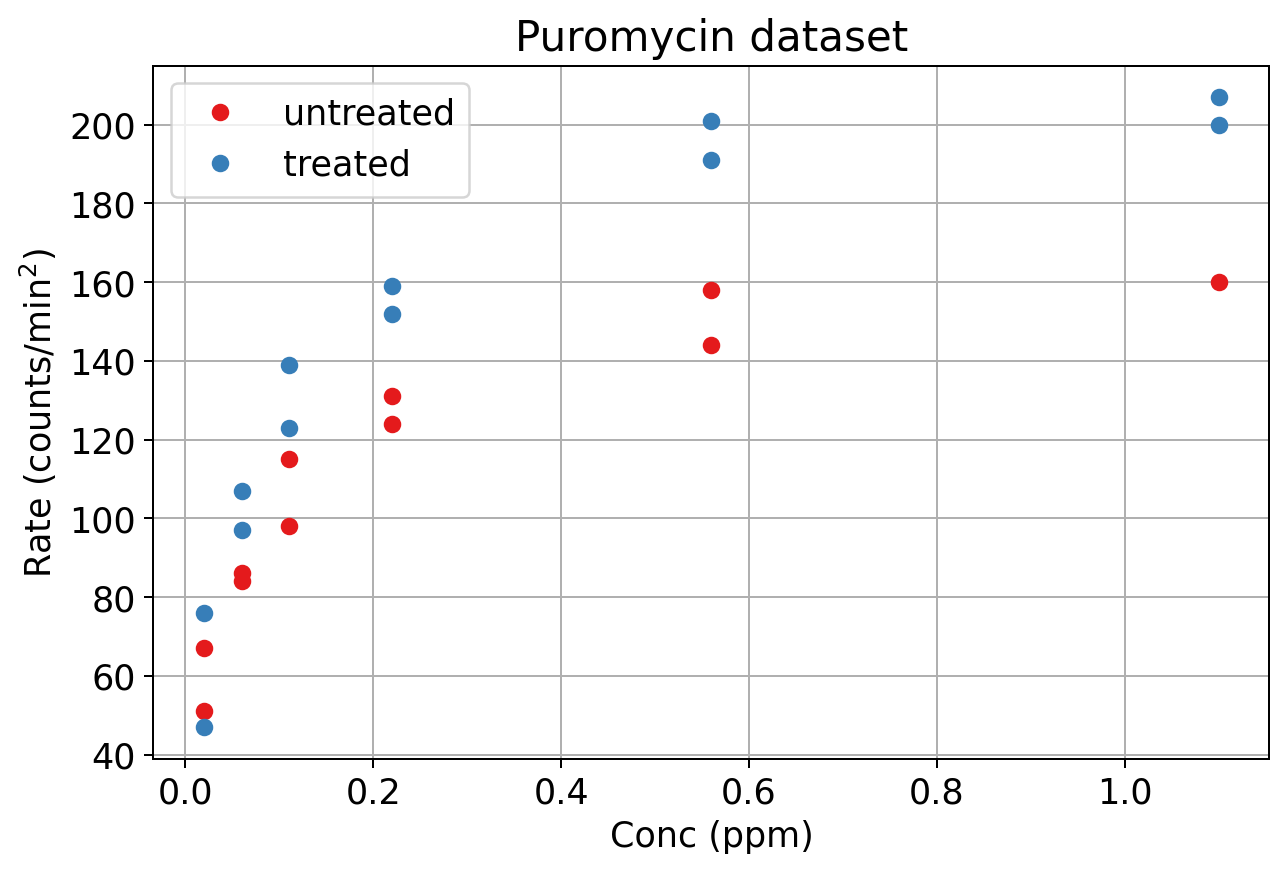

In [7]:
# Plot Rate -vs- Conc for each treatment
fig, ax = subplots(figsize = (8, 5))
for (t, df) in pairs(data)
    ax.plot(df.Conc, df.Rate, "o", label = t)
end
ax.set_xlabel("Conc (ppm)") 
ax.set_ylabel(L"Rate (counts/min$^2$)")
ax.set_title("Puromycin dataset")
ax.legend()
ax.grid(true);

### Define model and residual

The objective is to fit each dataset to the Michelis Menten model that relates the reaction rate, $v$, to the substrate concentration, $c$, by:
$$ v = \frac{V_{\text{max}} \cdot c}{K_m + c} $$

where $V_{\text{max}}$ is the maximal reaction rate, and the $K_m$ is the Michelis constant which is the substrate concentration for half-maximal reaction velocity ($v = V_{\text{max}}/2$ when $c = K_m$).

To fit the data to this model, first construct a residual function. 

In [8]:
# Michelis-Menten model
model(θ, c) = @. θ.Vmax * c / (θ.Km + c);

# Residual function
residual(θ, df) = df.Rate - model(θ, df.Conc);

### Fit data

Next, fit each dataset with `nlsfit` using optional arguments to set parameter lower bounds to 0, and to compute bootstrap confidence intervals

In [9]:
guess = (Vmax = 150, Km = 0.1);
fitter(df) = Fitty.nlsfit(residual, guess, data = df, lb = 0, bootstrap = true);
fits = Dict(t => fitter(df) for (t, df) in pairs(data));

Fit converged in 21 steps from intial guess [150.0, 0.1]
to final estimate [160.28, 0.048]
2000

 bootstrap fits converged out of 2000 tries


Fit results: 

Table with 5 columns and 2 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ Vmax       [0.0, Inf]  160.28     6.48025     [153.877, 165.704]
 2 │ Km         [0.0, Inf]  0.0477082  0.00778187  [0.0388035, 0.0556805]

Sum of squared residuals = 8.596e+02
Degrees of freedom = 11 - 2 = 9
Residual standard error = 9.773e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates
Fit converged in 17 steps from intial guess 

[150.0, 0.1]
to final estimate [212.684, 0.064]
2000

 bootstrap fits converged out of 2000 tries


Fit results: 

Table with 5 columns and 2 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ Vmax       [0.0, Inf]  212.684    6.94716     [206.73, 217.093]
 2 │ Km         [0.0, Inf]  0.0641213  0.00828095  [0.0547471, 0.0713151]

Sum of squared residuals = 1.195e+03
Degrees of freedom = 12 - 2 = 10
Residual standard error = 1.093e+01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


Output tables report fitted parameter values (`Estimate`), their standard errors (`StdErr`) and a 95% Bayesian credible interval (`CI`). 

### Overlay fits

The next plot shows the fits overlaid on the data

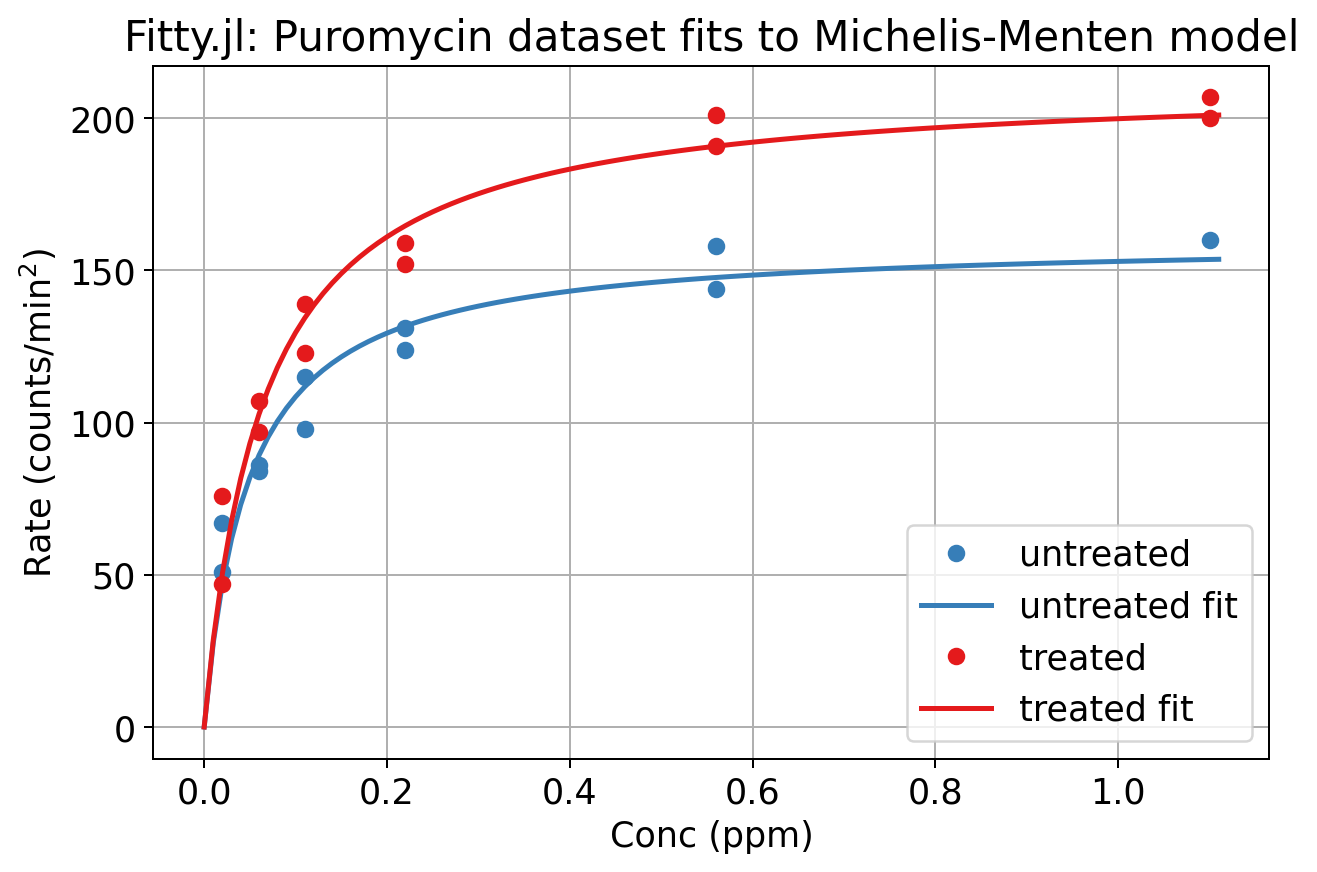

In [10]:
# Generate model predictions from fits
x = 0:0.01:1.11
pred = Dict(t => model(fits[t].fit, x) 
             for t in keys(fits)) 

# Plot data + prediction for each treatment
fig, ax = subplots(figsize = (8, 5))
colors = Dict(  "treated" => "C0", 
              "untreated" => "C1")
for t in keys(colors)
    df = data[t]
    ax.plot(df.Conc, df.Rate, "o",
            color = colors[t], label = t)
    y = pred[t]
    ax.plot(x, y, color = colors[t], lw =2, label = t * " fit")
end
ax.set_xlabel("Conc (ppm)") 
ax.set_ylabel(L"Rate (counts/min$^2$)")
ax.set_title("Fitty.jl: Puromycin dataset fits to Michelis-Menten model")
ax.legend()
ax.grid(true);

### Assess quality of fits

Plot residuals for each fit

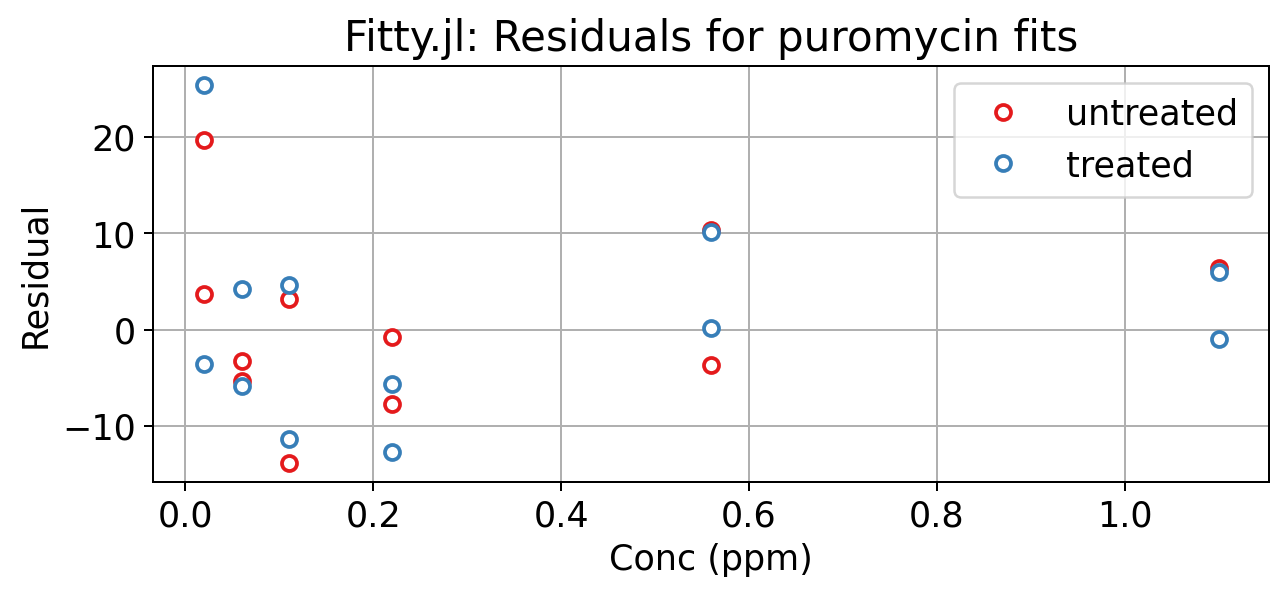

In [11]:
fig, ax = subplots(figsize = (8, 3))
for t in keys(data)
    x = data[t].Conc
    y = fits[t].residuals
    ax.plot(x, y, "o", mfc = "w", mew = 1.5, label = t)
end
ax.set_xlabel("Conc (ppm)") 
ax.set_ylabel("Residual")
ax.set_title("Fitty.jl: Residuals for puromycin fits")
ax.legend()
ax.grid(true);

Plot predicted -vs- observed rate

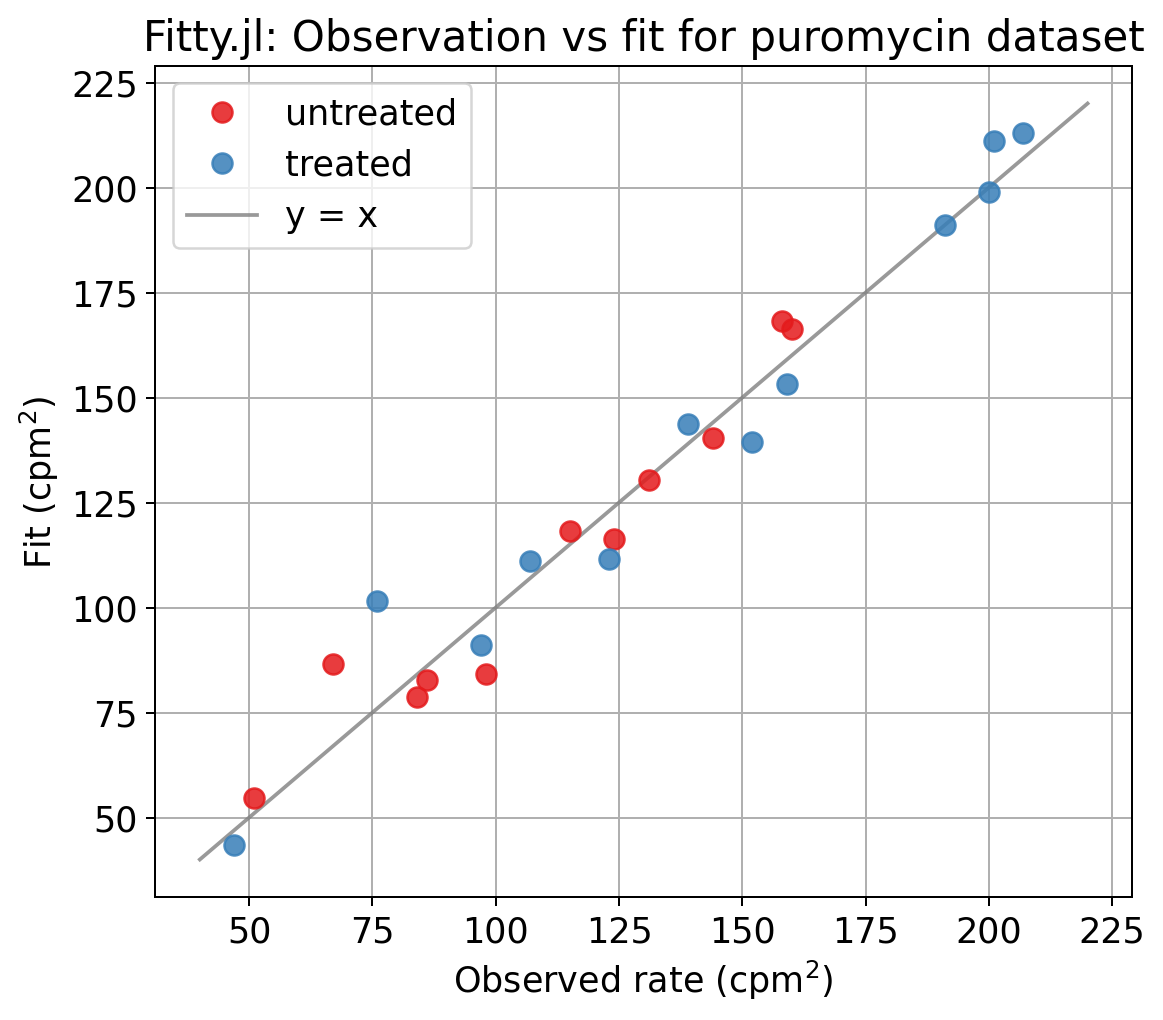

In [12]:
fig, ax = subplots(figsize = (7, 6))
for t in keys(data)
    x = data[t].Rate
    y = x + fits[t].residuals
    ax.plot(x, y, "o", ms = 8, alpha = 0.85, label = t)
end

# Add y = x line
x = [40, 220]
plot(x, x, color = "gray", lw = 1.5, 
     alpha = 0.8, zorder = 1, label = "y = x")

ax.set_xlabel(L"Observed rate (cpm$^2$)") 
ax.set_ylabel(L"Fit (cpm$^2$)")
ax.set_title("Fitty.jl: Observation vs fit for puromycin dataset")
ax.legend()
ax.grid(true);

### Analyze parameter distributions

Plot parameter posterior distributions

In [13]:
# Estimate kernel densities from bootstrap posterior
post = Dict(t => Fitty.posteriorPDF(fits[t]) 
            for t in ("treated", "untreated"))
Vmax_untrt_kde = kde(post["untreated"].Vmax)
Km_untrt_kde = kde(post["untreated"].Km)
Vmax_trt_kde = kde(post["treated"].Vmax)
Km_trt_kde = kde(post["treated"].Km);

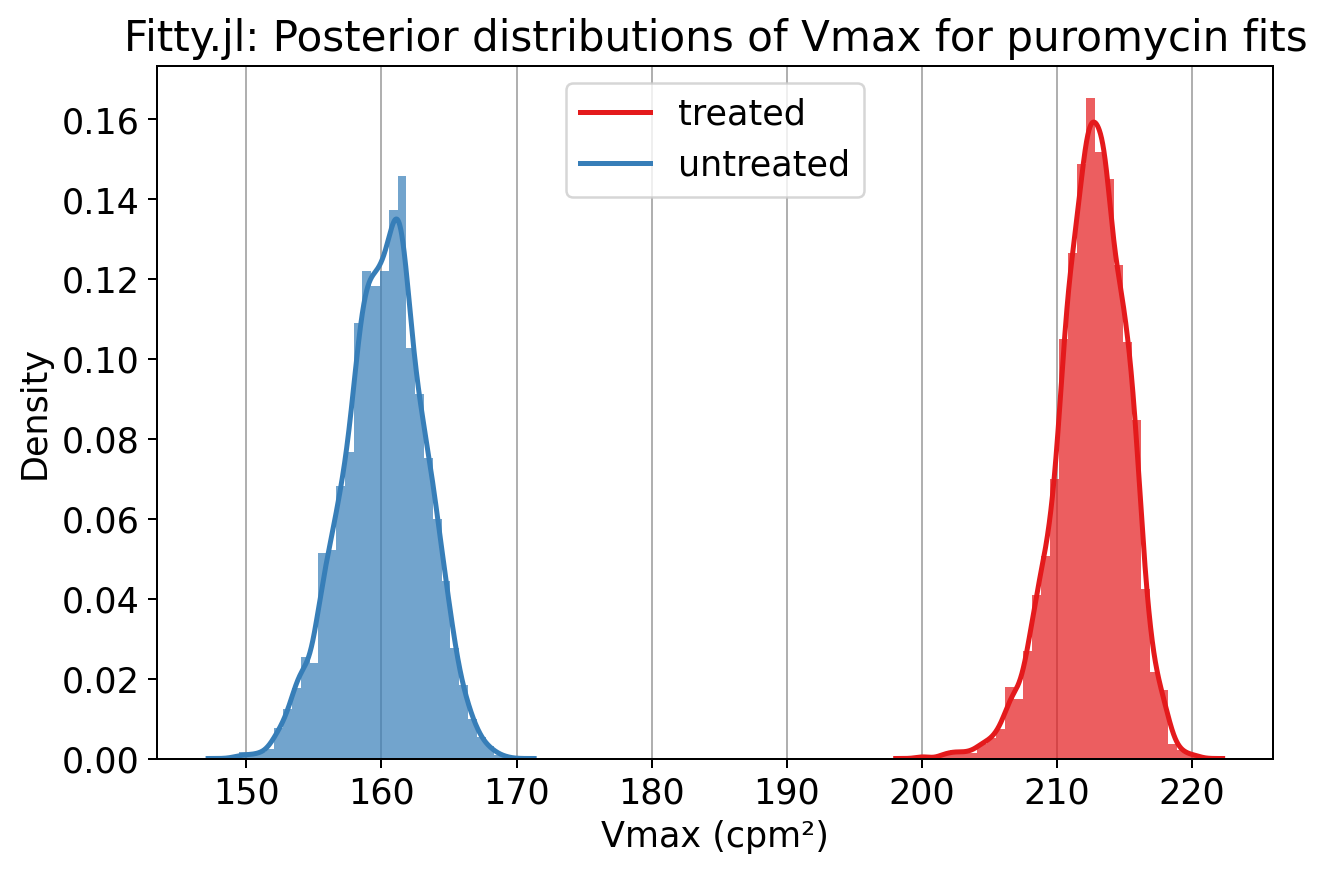

In [14]:
# Plot posterior densities of Vmax
fig, ax = subplots(figsize = (8, 5))

nbins = 30
ax.hist(post["treated"].Vmax, 
         bins = nbins, density = true, 
         alpha = 0.7)
d = Vmax_trt_kde
ax.plot(d.x, d.density, 
        label = "treated",
        lw = 2, color = "C0")

ax.hist(post["untreated"].Vmax, 
         bins = nbins, density = true, 
         alpha = 0.7)
d = Vmax_untrt_kde
ax.plot(d.x, d.density, 
        label = "untreated",
        lw = 2, color = "C1")

ax.legend(loc = "upper center")
ax.xaxis.grid(true)
ax.set_xlabel("Vmax (cpm²)")
ax.set_ylabel("Density")
ax.set_title("Fitty.jl: Posterior distributions of Vmax for puromycin fits");

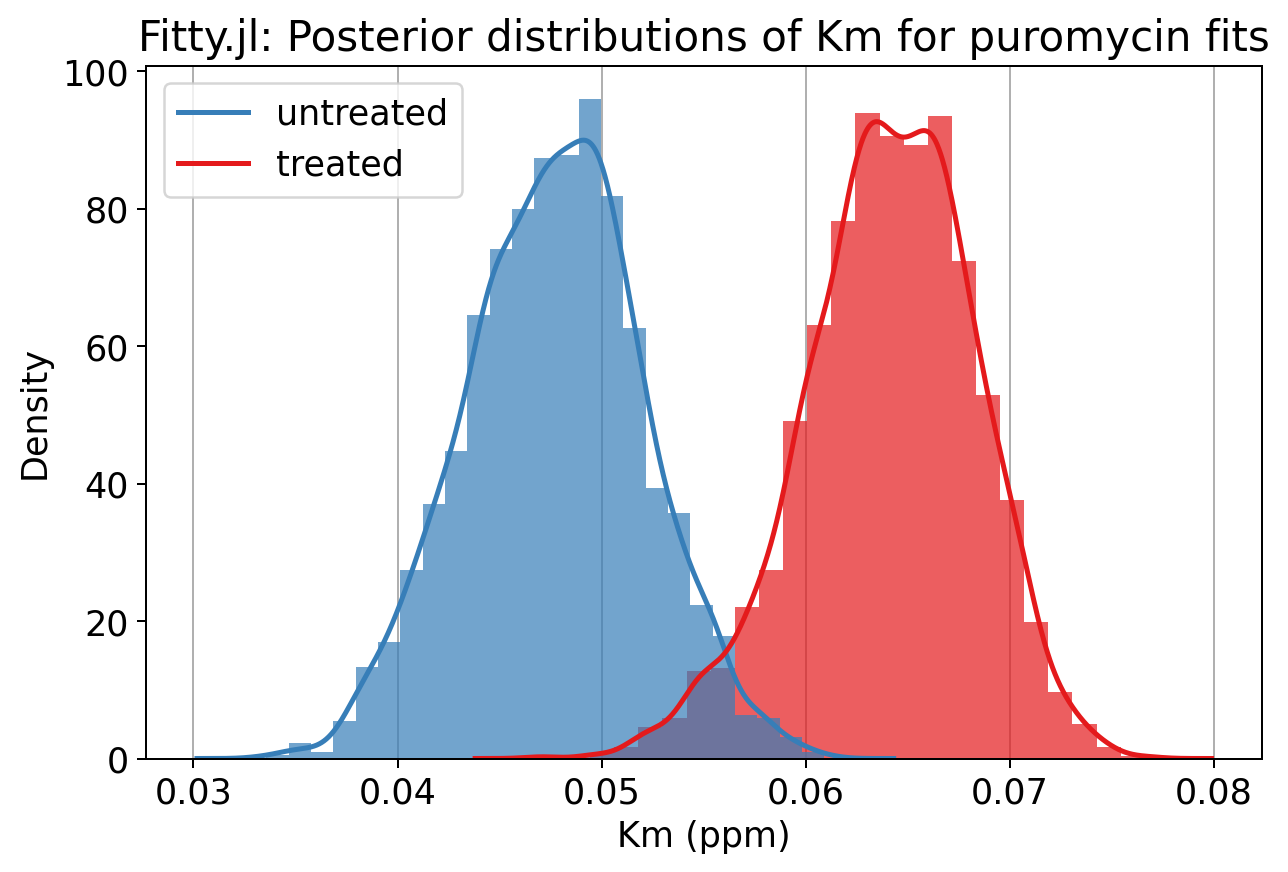

In [15]:
# Plot posterior densities of Km
fig, ax = subplots(figsize = (8, 5))

nbins = 25
ax.hist(post["treated"].Km, 
         bins = nbins, density = true, 
         alpha = 0.7)
d = Km_untrt_kde
ax.plot(d.x, d.density, 
        label = "untreated",
        lw = 2, color = "C1")

ax.hist(post["untreated"].Km, 
         bins = nbins, density = true, 
         alpha = 0.7)
d = Km_trt_kde
ax.plot(d.x, d.density, 
        label = "treated",
        lw = 2, color = "C0")

ax.legend()
ax.set_xlabel("Km (ppm)")
ax.xaxis.grid(true)
ax.set_ylabel("Density")
ax.set_title("Fitty.jl: Posterior distributions of Km for puromycin fits");

Plots of joint posterior density

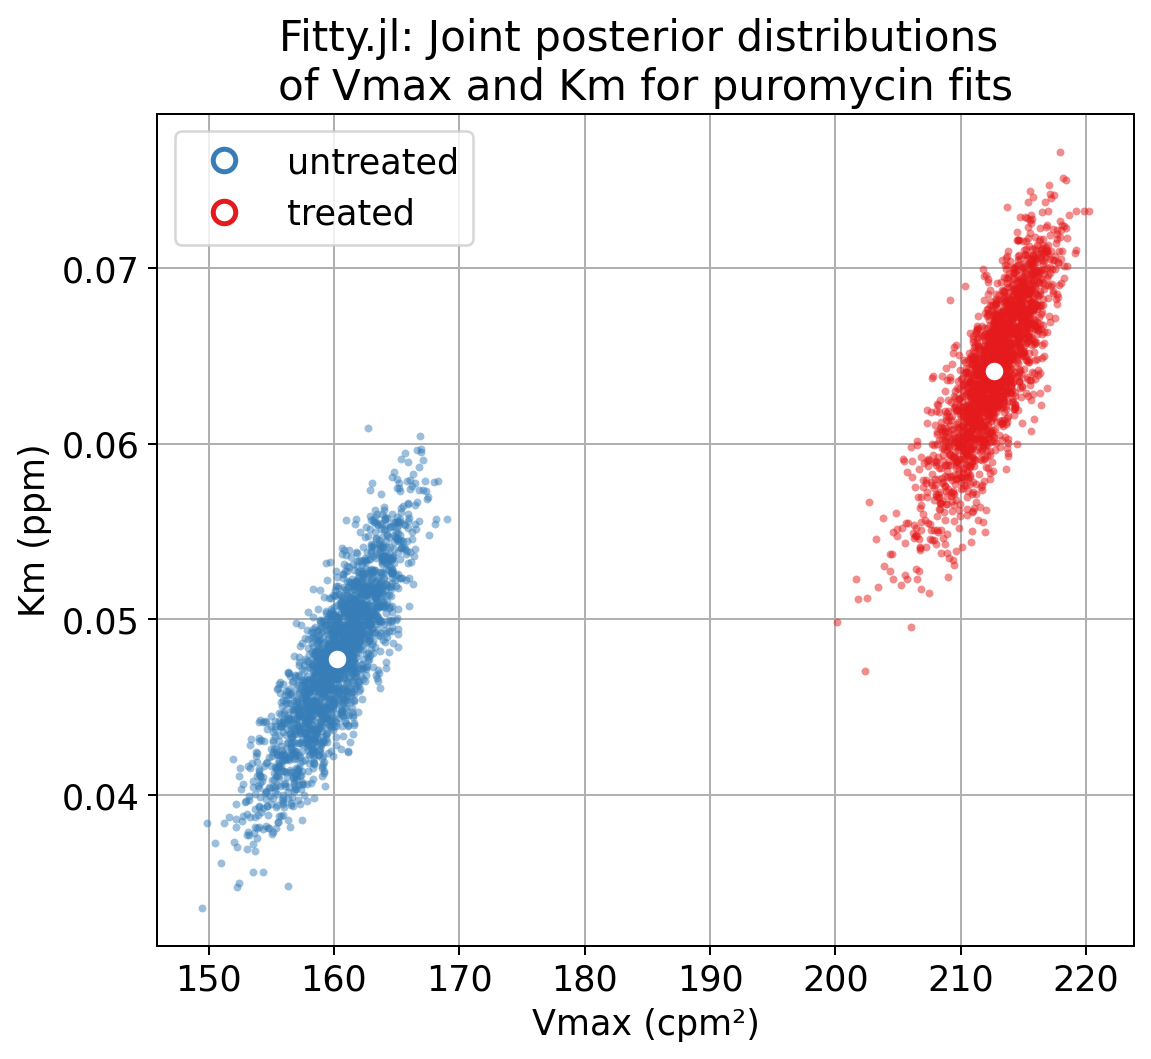

In [16]:
# Plot posterior densities of Km
colors = Dict("treated" => "C0", "untreated" => "C1")
fig, ax = subplots(figsize = (7, 6))
for (t, df) in post
    color = colors[t]
    ax.scatter(df.Vmax, df.Km, color = color,
            s = 10, lw = 0, alpha = 0.5)
    fit = fits[t].fit
    ax.plot([fit.Vmax], [fit.Km], "o", color = color,
            ms = 9, mfc = "w", mew = 2, label = t)
end
ax.legend()
ax.set_xlabel("Vmax (cpm²)")
ax.set_ylabel("Km (ppm)")
ax.grid()
ax.set_title("Fitty.jl: Joint posterior distributions \nof Vmax and Km for puromycin fits");